In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
import cv2
import numpy as np
import random
import os
import pandas as pd
import warnings
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Activation, Multiply, Reshape,
    GlobalAveragePooling2D, Dense, AveragePooling2D, Lambda, BatchNormalization
)
from tensorflow.keras.models import Model

C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
import tensorflow as tf

# Create three independent generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\train",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\val",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\test",
    target_size=(224, 224),
    batch_size=16,
    shuffle=False  # don't shuffle for evaluation/prediction
)

print("Train classes:", train_generator.class_indices)
print("Validation classes:", val_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Found 6660 images belonging to 4 classes.
Found 1918 images belonging to 4 classes.
Found 1293 images belonging to 4 classes.
Train classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Validation classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Test classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
def CALayer(x, channels, reduction=16, name="ca"):

    # Global average pooling: N×H×W×C → N×C
    y = layers.GlobalAveragePooling2D(name=f"{name}_gap")(x)

    # FC layers (1x1 conv equivalents)
    y = layers.Dense(
        channels // reduction,
        activation='relu',
        use_bias=True,
        name=f"{name}_fc1"
    )(y)

    y = layers.Dense(
        channels,
        activation='sigmoid',
        use_bias=True,
        name=f"{name}_fc2"
    )(y)

    # Reshape to N×1×1×C
    y = layers.Reshape((1, 1, channels), name=f"{name}_reshape")(y)

    # Channel-wise scaling
    out = layers.Multiply(name=f"{name}_scale")([x, y])

    return out

def channel_shuffle(x, groups):
    # x: [N, H, W, C]
    batch_size = tf.shape(x)[0]
    height = tf.shape(x)[1]
    width = tf.shape(x)[2]
    channels = x.shape[-1]   # static channel count

    channels_per_group = channels // groups

    # reshape: (N, H, W, groups, C // groups)
    x = tf.reshape(x, [batch_size, height, width, groups, channels_per_group])

    # transpose: swap group and channel dims
    x = tf.transpose(x, [0, 1, 2, 4, 3])

    # flatten
    x = tf.reshape(x, [batch_size, height, width, channels])

    return x
def grouped_conv1x1(x, out_channels, groups, use_bn=True, use_relu=False, name=None):

    x = layers.Conv2D(
        out_channels,
        kernel_size=1,
        strides=1,
        padding='valid',
        groups=groups,
        use_bias=True,
        name=None if name is None else f"{name}_conv"
    )(x)

    if use_bn:
        x = layers.BatchNormalization(name=None if name is None else f"{name}_bn")(x)

    if use_relu:
        x = layers.ReLU(name=None if name is None else f"{name}_relu")(x)

    return x
def Shuffle3x3(x, in_channels, out_channels, groups=3, grouped_conv=True, name="shuffle3x3"):

    bottleneck_channels = out_channels // 4
    first_1x1_groups = groups if grouped_conv else 1

    residual = x

    # 1x1 grouped conv (compress)
    x = grouped_conv1x1(
        x,
        bottleneck_channels,
        groups=first_1x1_groups,
        use_bn=True,
        use_relu=True,
        name=f"{name}_compress"
    )

    # channel shuffle
    x = layers.Lambda(lambda z: channel_shuffle(z, groups),
                      name=f"{name}_shuffle")(x)

    # depthwise 3x3 conv
    x = layers.DepthwiseConv2D(
        kernel_size=3,
        strides=1,
        padding='same',
        use_bias=True,
        name=f"{name}_dwconv3x3"
    )(x)

    x = layers.BatchNormalization(name=f"{name}_dw_bn")(x)

    # 1x1 grouped conv (expand)
    x = grouped_conv1x1(
        x,
        out_channels,
        groups=groups,
        use_bn=True,
        use_relu=False,
        name=f"{name}_expand"
    )

    # residual + relu
    x = layers.Add(name=f"{name}_add")([x, residual])
    x = layers.ReLU(name=f"{name}_relu")(x)

    return x
def Shuffle5x5(x, in_channels, out_channels, groups=3, grouped_conv=True, name="shuffle5x5"):

    bottleneck_channels = out_channels // 4
    first_1x1_groups = groups if grouped_conv else 1

    residual = x

    # 1x1 grouped conv (compress)
    x = grouped_conv1x1(
        x,
        bottleneck_channels,
        groups=first_1x1_groups,
        use_bn=True,
        use_relu=True,
        name=f"{name}_compress"
    )

    # channel shuffle
    x = layers.Lambda(lambda z: channel_shuffle(z, groups),
                      name=f"{name}_shuffle")(x)

    # depthwise "5x5" (kept SAME as PyTorch)
    x = layers.DepthwiseConv2D(
        kernel_size=3,   # intentionally 3, matching your code
        strides=1,
        padding='same',
        use_bias=True,
        name=f"{name}_dwconv5x5"
    )(x)

    x = layers.BatchNormalization(name=f"{name}_dw_bn")(x)

    # 1x1 grouped conv (expand)
    x = grouped_conv1x1(
        x,
        out_channels,
        groups=groups,
        use_bn=True,
        use_relu=False,
        name=f"{name}_expand"
    )

    # residual + relu
    x = layers.Add(name=f"{name}_add")([x, residual])
    x = layers.ReLU(name=f"{name}_relu")(x)

    return x
    
def DRB(x, n_features, groups=4, name="drb"):

    x_3x3 = Shuffle3x3(
        x,
        in_channels=n_features,
        out_channels=n_features,
        groups=groups,
        name=f"{name}_s3"
    )

    x_5x5 = Shuffle5x5(
        x,
        in_channels=n_features,
        out_channels=n_features,
        groups=groups,
        name=f"{name}_s5"
    )

    out = layers.Concatenate(axis=-1, name=f"{name}_concat")([x_3x3, x_5x5])

    out = layers.Conv2D(
        n_features,
        kernel_size=3,
        padding='same',
        use_bias=True,
        name=f"{name}_outconv"
    )(out)

    out = layers.ReLU(max_value=6.0, name=f"{name}_relu6")(out)

    return out


def RDAB(x, n_blocks, n_features, reductions=16, name="rdab"):

    # ----- body path (MSB in your code) -----
    x_msb = x
    for i in range(n_blocks):
        x_msb = DRB(x_msb, n_features, name=f"{name}_drb_{i}")
        if i == n_blocks - 1:
            x_msb = layers.Activation('sigmoid',
                                      name=f"{name}_sigmoid")(x_msb)

    # ----- channel attention path -----
    x_ca = CALayer(x, n_features, reductions, name=f"{name}_ca")

    # ----- fusion -----
    out = layers.Add(name=f"{name}_add")([x_msb, x_ca])
    out = layers.ReLU(name=f"{name}_relu")(out)

    return out

def DRDANet(input_shape=(224, 224, 3), num_blocks=4, num_classes=2):

    inputs = layers.Input(shape=input_shape)

    # -------- Initial conv --------
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x1 = layers.MaxPooling2D((2, 2))(x)   # 112×112×32

    # -------- Stage 1 --------
    x2 = RDAB(x1, num_blocks, 32, reductions=16, name="rdab1")
    x2 = layers.Concatenate(axis=-1)([x1, x2])  # 64
    x2 = layers.MaxPooling2D((2, 2))(x2)        # 56×56×64

    # -------- Stage 2 --------
    x3 = RDAB(x2, num_blocks, 64, reductions=16, name="rdab2")
    x3 = layers.Concatenate(axis=-1)([x3, x2])  # 128

    x1_1 = layers.MaxPooling2D((2, 2))(x1)       # 56×56×32
    x3 = layers.Concatenate(axis=-1)([x3, x1_1])  # 160

    x3 = layers.Conv2D(128, 3, padding='same')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.ReLU()(x3)
    x3 = layers.MaxPooling2D((2, 2))(x3)         # 28×28×128

    # -------- Stage 3 --------
    x4 = RDAB(x3, num_blocks, 128, reductions=16, name="rdab3")
    x4 = layers.Concatenate(axis=-1)([x4, x3])   # 256

    x2_1 = layers.MaxPooling2D((2, 2))(x2)       # 28×28×64
    x4 = layers.Concatenate(axis=-1)([x4, x2_1]) # 320

    x1_2 = layers.MaxPooling2D((2, 2))(x1_1)     # 28×28×32
    x4 = layers.Concatenate(axis=-1)([x4, x1_2]) # 352

    x4 = layers.Conv2D(256, 3, padding='same')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.ReLU()(x4)
    x4 = layers.MaxPooling2D((2, 2))(x4)         # 14×14×256

    # -------- Stage 4 --------
    x5 = RDAB(x4, num_blocks, 256, reductions=16, name="rdab4")
    x5 = layers.Concatenate(axis=-1)([x5, x4])   # 512

    x3_1 = layers.MaxPooling2D((2, 2))(x3)       # 14×14×128
    x5 = layers.Concatenate(axis=-1)([x5, x3_1]) # 640

    x2_2 = layers.MaxPooling2D((2, 2))(x2_1)     # 14×14×64
    x5 = layers.Concatenate(axis=-1)([x5, x2_2]) # 704

    x1_3 = layers.MaxPooling2D((2, 2))(x1_2)     # 14×14×32
    x5 = layers.Concatenate(axis=-1)([x5, x1_3]) # 736

    x5 = layers.Conv2D(512, 3, padding='same')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.ReLU()(x5)

    # -------- Head --------
# -------- Head --------
    out = layers.MaxPooling2D((2, 2))(x5)        # 7×7×512
    out = layers.GlobalAveragePooling2D()(out)   # 512
    out = layers.Dense(4, activation='softmax')(out)
    
    model = models.Model(inputs, out, name="DRDANet")
    return model

model = DRDANet()
model.summary()

dummy = tf.random.normal((1, 224, 224, 3))
out = model(dummy)

print(out.shape)  # (1, 2)


Model: "DRDANet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 224, 224, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [4]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='drdanet_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]
history = model.fit(
    train_generator,
    epochs=65,
    validation_data=val_generator,
    callbacks=callbacks
)



Epoch 1/65
417/417 [==============================] - 166s 371ms/step - loss: 0.7615 - accuracy: 0.6661 - val_loss: 1.4552 - val_accuracy: 0.4604

Epoch 00001: val_accuracy improved from -inf to 0.46038, saving model to drdanet_best.h5


C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/65
417/417 [==============================] - 152s 364ms/step - loss: 0.6193 - accuracy: 0.7257 - val_loss: 0.8920 - val_accuracy: 0.6929

Epoch 00002: val_accuracy improved from 0.46038 to 0.69291, saving model to drdanet_best.h5
Epoch 3/65
417/417 [==============================] - 151s 362ms/step - loss: 0.5640 - accuracy: 0.7532 - val_loss: 1.7293 - val_accuracy: 0.4108

Epoch 00003: val_accuracy did not improve from 0.69291
Epoch 4/65
417/417 [==============================] - 151s 362ms/step - loss: 0.5237 - accuracy: 0.7799 - val_loss: 1.3322 - val_accuracy: 0.5824

Epoch 00004: val_accuracy did not improve from 0.69291
Epoch 5/65
417/417 [==============================] - 151s 362ms/step - loss: 0.4969 - accuracy: 0.7817 - val_loss: 1.8072 - val_accuracy: 0.4526

Epoch 00005: val_accuracy did not improve from 0.69291
Epoch 6/65
417/417 [==============================] - 151s 362ms/step - loss: 0.4674 - accuracy: 0.7965 - val_loss: 1.1886 - val_accuracy: 0.5334

Epoch 00

In [5]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


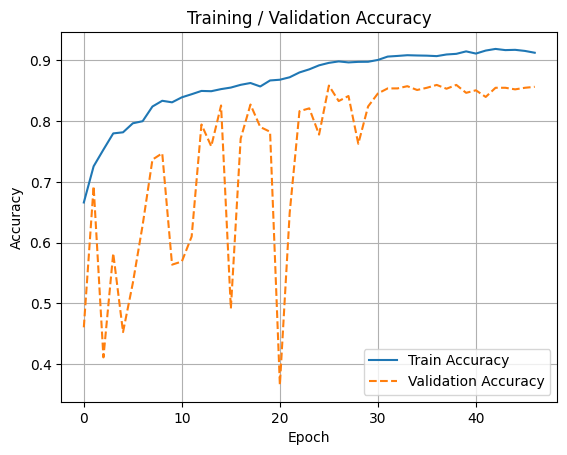

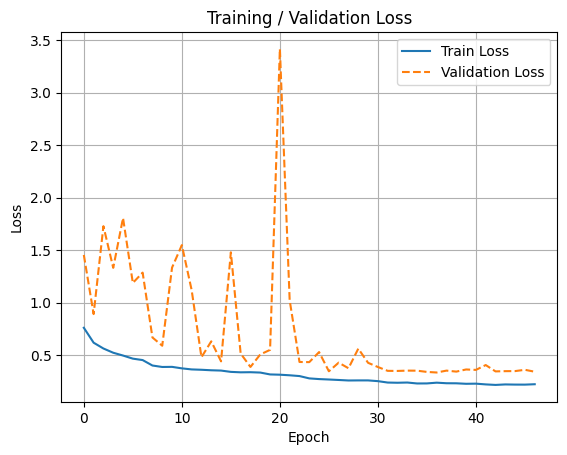

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '--')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.title('Training / Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '--')
plt.legend(['Train Loss', 'Validation Loss'])
plt.title('Training / Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [7]:
# vgg16model.load_weights("./cropModel.h5")
class_labels = test_generator.class_indices
oriningal_test_classes = test_generator.labels
print(class_labels)
print("Original test classes")
print(oriningal_test_classes)

Y_pred =model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print("Predicted test classes")
print(y_pred)

{'A': 0, 'B': 1, 'C': 2, 'D': 3}
Original test classes
[0 0 0 ... 3 3 3]
Predicted test classes
[0 0 0 ... 3 3 3]


In [8]:
print('Accuracy {}'.format(accuracy_score(y_true=test_generator.labels, y_pred=y_pred)))
print('F1 {}'.format(f1_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('precision {}'.format(precision_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('recall {}'.format(recall_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('classification_report\n {}'.format(classification_report(y_true=test_generator.labels, y_pred=y_pred)))
print('\n\n')
cm = confusion_matrix(y_true=test_generator.labels, y_pred=y_pred)
print(cm)

Accuracy 0.888631090487239
F1 0.872175711848435
precision 0.8679639029892837
recall 0.8770587240391794
jaccard 0.7806601012588128
classification_report
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       466
           1       0.80      0.81      0.80       233
           2       0.84      0.83      0.84       411
           3       0.83      0.89      0.86       183

    accuracy                           0.89      1293
   macro avg       0.87      0.88      0.87      1293
weighted avg       0.89      0.89      0.89      1293




[[456   3   1   6]
 [  0 188  42   3]
 [  0  44 342  25]
 [  0   0  20 163]]
